<a href="https://colab.research.google.com/github/MohamedBechir361/Optimisation-Projects/blob/main/BESS_Optimisation/BESS_Optimisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MILP-based Optimisation Model for BESS Economic Dispatch and EVs Smart Charging

This project aims to create an optimisation model

Ensure building's electrical demand

Manage BESS charge/discharge cycles

Place the charging of the EV fleet

Respect the Demand Response signals


## Model Formultion


In [1]:
!pip install gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 101.9 MB/s eta 0:00:00


In [2]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt

### Sets

**Time Indices and Sets**

- $t$ : Time index (hourly resolution)  
- $b$ : FCR block index (4-hour blocks)  
- $\mathcal{T}_{DR}$ : Set of time periods subject to demand response  
- $\mathcal{T}_{EV}$ : Set of time periods for EV fleet charging

In [3]:
T = np.arange(0,24) # Time periods
T_DR = np.array([16,17,18])
T_EV = np.arange(8,19)
B = { i:[i*4,i*4+1, i*4+2, i*4+3 ] for i in range(6)} # Blocs of ancillary services products

## Data

**Battery Parameters**

- $E^{max}$ : Battery energy capacity [kWh]  
- $P^{ch,max}$ : Maximum charging power [kW]  
- $P^{dis,max}$ : Maximum discharging power [kW]  
- $\eta^{ch}$ : Charging efficiency [-]  
- $\eta^{dis}$ : Discharging efficiency [-]  
- $SOC^{min}$ : Minimum SOC fraction [-]  
- $SOC^{max}$ : Maximum SOC fraction [-]  
- $\Delta t$ : Time step duration (1 hour)  

**EV Parameters**
  
- $P^{EV,max}$ : Maximum EV charging power [kW]  
- $E^{EV,req}$ : Required EV energy by departure [kWh]  

**Load, Generation, and Grid Parameters**

- $L_t$ : Local electrical load [kW]  
- $PV_t$ : PV generation [kW]  
- $P^{grid,max}$ : Maximum grid import power [kW]  
- $P^{exp,max}$ : Maximum grid export power [kW]  

**Demand Response Parameters**

- $Baseload_t$ : Baseline demand during DR period [kW]  
- $\alpha$ : Required demand reduction fraction [-]  
- $s_t$ : DR slack variable (soft constraint) [kW]  

**Reserve Activation Parameters**

- $T^{FCR}$ : Expected upward/downward FCR activation duration [h]  
- $T^{aFRR,down}$ : Expected upward aFRR activation duration [h]  
- $T^{aFRR,down}$ : Expected downward aFRR activation duration [h]  
- $T^{mFRR,up}$ : Expected upward mFRR activation duration [h]  


In [42]:
PVmax = 150*10 # Maximum Installed Capacity of Solar PV in kW, covering a 200-place parking
PV = np.array([
    0, 0, 0, 0, 0, 5,
    20, 50, 90, 130, 150, 145,
    140, 135, 130, 120, 90, 50,
    15, 0, 0, 0, 0, 0
]) * 10                           # for a 1500 kWp module

N_EV = 0.75 *200 # Number of EVs in fleet, assuming 75% of vehicules are EVs.
E_per_EV = 10 # Required Energy per EV in kWh.
EVEreq = N_EV*E_per_EV # Energy Requirement for EV in kWh for total fleet.
PEVmax = 7.4*30 # Maximum Charging Power for EV in kW for total fleet, assuming a Wallbox (7.4 kW) and 30 chargers.

Pmax = 3000 # Maximum Capacity for BESS, 3 MW
duration = 2 # Duration of storage
Emax = Pmax * duration  # Maximum Energy for BESS
eta = 0.9 # BESS Efficiency
SoC_init = 0.5*Emax

CCap = 52500 # Contracted Capacity for Grid
FIT = 0.0761 # €/kWh

Baseload = np.array([ 21250.        , 20000.        , 19500.        , 19250.        ,
                      19000.        , 19250.        , 20300.        , 29500.        ,
                      34100.        , 34795.78947368, 37650.        , 38950.        ,
                      38500.        , 39050.        , 37850.        , 36700.        ,
                      36500.        , 35750.        , 32350.        , 24800.        ,
                      23750.        , 22000.        , 21500.        , 19620.        ])
alpha = 0.1

Load_curve = np.array([
    850, 800, 780, 770, 760, 770,
    820, 1200, 1400, 1500, 1550, 1600,
    1580, 1600, 1550, 1500, 1480, 1450,
    1300, 1100, 950, 880, 860, 840
])* 25                                    # To consume around 25 GWh/year

# Example price profile (€/kWh)
"""spot_prices = [

    0.120, 0.115, 0.11, 0.120, 0.110, 0.120,
     0.100, 0.090, 0.085, 0.01, 0.005,0.005,
    0.005, 0.008, 0.010, 0.015, 0.020, 0.05,
     0.085, 0.155,0.130, 0.135, 0.120, 0.110
]"""

spot_prices = np.array([20.88,   6.66,  12.54,   5.59,   0.4 ,  12.49,  60.01,  97.56,
                        115.  , 105.18,  93.49,  74.93,  71.25,  73.12,  79.76,  85.  ,
                        100.64, 118.34, 128.87, 125.  , 107.24, 100.55,  98.53,  89.27])/1000    # €/MWh VERS €/kWh, for 7/01/2025


# prices for 01/01/2026 in France in €/MW/15min

FCR_prices = np.array([4.83, 2.86, 2.55, 1.80, 4.94, 4.82])*4/1000  # €/kW/h

aFRR_prices_up = np.array([7.73, 8.74, 9.81, 3.15, 4.28, 1.47, 1.73, 2.06, 3.10, 3.10, 1.27, 0.71,
                  1.55, 0.84, 0.53, 2.25, 10.31, 9.55, 6.41, 5.22, 2.87, 7.74, 8.94, 7.70])*4/1000  # €/kW/h

aFRR_prices_down = np.array([4.89, 5.78, 3.84, 1.66, 0.82, 0.88, 0.89, 1.18, 1.08, 1.30, 1.03, 0.91,
                    0.98, 0.68, 0.78, 0.91, 0.73, 1.15, 1.06, 1.33, 4.26, 3.25, 2.42, 2.35])*4/1000  # €/kW/h

mFRR_price_up = 0.05*4/1000  # €/kW/h, one price all day
mFRR_price_down = 0

M = 10000000 # Penality

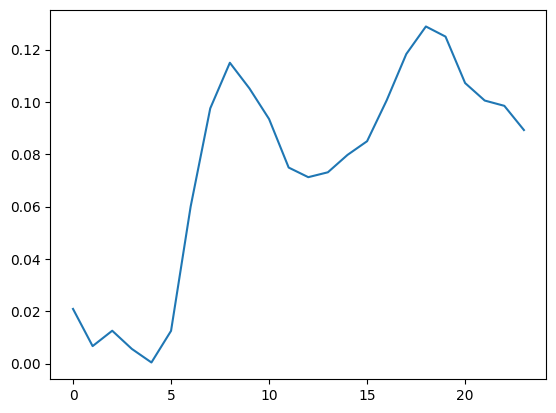

In [43]:
plt.plot(T,spot_prices)
plt.show()

In [44]:
SoCmin = 0.2*Emax
SoCmax = 0.8*Emax
a_FCR = 0.25    # 15 min maximum activation of FCR
a_aFRR = 1.0    # 1h maximum activation for aFRR
a_mFRR_down = 0.25 # 15 min maximum activation of mFRR down
a_mFRR_up = 4 # 4h maximum activation of mFRR up, 1 hour/activation (assumption)

## Variables

In [45]:
model = gp.Model('BESS_Dispatch')

**Power Decision Variables**

- $P^{ch}_t$ : Battery charging power [kW]  
- $P^{dis}_t$ : Battery discharging power [kW]  
- $P^{EV}_t$ : EV charging power [kW]   

**Energy and State Variables**

- $SoC_t$ : Battery state of charge [kWh]   

**Binary Variables**

- $u^{ch}_t \in \{0,1\}$ : Battery charging indicator  
- $u^{dis}_t \in \{0,1\}$ : Battery discharging indicator  

**Slack Variables**

- $e_t$ : Slack variable for maximum SoC constraint
- $d_t$ : Slack variable for minimum SoC constraint
- $s_t$ : Slack variable for DR constraint

**Solar Panels Variables**

- $AC_t$ : Solar autoconsumption [kW]
- $S^{ch}_t$ : Solar to BESS charge [kW]
- $S^{inj}_t$ : Solar Injection to grid [kW]
- $Curt_t$ : Curtailed Solar production [kW]

**Grid Variables**

- $C^{Grid}_t$ : Electricity consumption from grid [kW]
- $G^{ch}_t$ : Grid to BESS charge [kW]
- $B^{dis}_t$ : BESS to Grid discharge [kW]

In [46]:
# BESS
P_ch = model.addVars(T, lb = 0, ub = Pmax, vtype=GRB.CONTINUOUS, name='BESS Charge')
P_dis = model.addVars(T, lb=0, ub = Pmax, vtype=GRB.CONTINUOUS, name='BESS Discharge')
SoC = model.addVars(T, lb = 0, ub = Emax, vtype=GRB.CONTINUOUS, name='State of Charge')
U_ch = model.addVars(T, vtype = GRB.BINARY, name='Charging Status')   # 1 if BESS is charging, 0 else
U_dis = model.addVars(T, vtype = GRB.BINARY, name='Discharging Status')
GRID_to_BESS = model.addVars(T,lb=0, ub = CCap, vtype=GRB.CONTINUOUS, name='GRID to BESS')
BESS_to_GRID = model.addVars(T,lb=0, ub = CCap, vtype=GRB.CONTINUOUS, name='BESS to GRID')

# Slack
e = model.addVars(T, lb = 0, ub = 0.2*Pmax, vtype=GRB.CONTINUOUS, name='Slack for SoCmax')
d = model.addVars(T, lb = 0, ub = 0.2*Pmax, vtype=GRB.CONTINUOUS, name='Slack for SoCmin')

# Grid
P_grid = model.addVars(T,lb=0, ub = CCap, vtype=GRB.CONTINUOUS, name='Grid Consumption') # CCap stands for contracted capacity

# Solar PV
AC = model.addVars(T, lb=0, ub = PVmax, vtype=GRB.CONTINUOUS, name='Autoconsumption of PV')
S_ch = model.addVars(T, lb=0, ub = PVmax, vtype=GRB.CONTINUOUS, name='Solar to BESS')
S_inj = model.addVars(T, lb=0, ub = PVmax, vtype=GRB.CONTINUOUS, name='Solar Injection')
Curt = model.addVars(T, lb=0, ub = PVmax, vtype=GRB.CONTINUOUS, name='Curtailement')

# EVs
PEV = model.addVars(T_EV, lb=0, ub = PEVmax, vtype=GRB.CONTINUOUS, name='EV Charging Power')

# Demand Response
s = model.addVars(T_DR, lb=0, vtype=GRB.CONTINUOUS, name='Slack for DR Constraint')

model.update()

A BESS can participate in ancillary services and contribute to the frequency regulation. In the French market, an similar to other european contries, there are 3 types of reserves (or products) to which the BESS can participate and generate more revenues.

The Frequency Containment Reserve (FCR), also known as the primary reserve is automtically activated within seconds of the TSO's notification. It is a symmetrical product (up and down) that can be bid during 6 specified 4h-windows during a day. The revenues come from the certified capacity in a pay-as-clear process, and the activated energy is paid at a 15-minutes spot electricity prices. The minium size of the bid is of 1 MW, with an round number of MWs, and the maximum activation duration is about 15 minutes.

The aFRR, or secondary reserve, is also automatically activated after the FCR. This product can be asymetrical (up or down), or symetrial (but they will not be accepted from 2026). This product can be bid at any hour of the day, with a minimum of 1 MW and an entire number of MWs. The activation duration can be up to 1h, so sufficient charge in the BESS need to be considered. The revenues are accouted the same way as the FCR.

The mFRR or manual ... is known as the tertiary reserve. This product exist in two daily forms : mFRR up and mFRR down, each having different conditons.
The mFRR up is a one-day available contracted power, that can be activated anytime of the day and up to 4 activation during a day. The activation duration is at most 4h during one day (We can assume a 1h/activation).
The mFRR down is defined by a starting and ending period, expressed in full hours, and can be activated up to 15 minutes. The same rules in terms of capacity apply to this product as well.
The revenues for both mFRR products are similar to FCR and aFRR.

In this project, we consider that all ours offers (bids) are undividebale in order to simplify the modelling of the products. Additionally, we relax the constraint of entire MWs in a bid.




**Reserve Capacity Variables**

**FCR (Block-Based)**

- $R^{FCR}_b$ : Upward/Downward FCR reserve capacity [kW]  

**aFRR (Hourly)**

- $R^{aFRR,up}_t$ : Upward aFRR reserve capacity [kW]  
- $R^{aFRR,down}_t$ : Downward aFRR reserve capacity [kW]  

**mFRR (Fixed all-day)**

- $R^{mFRR,up}$ : Upward mFRR reserve capacity [kW]   


In [47]:
# Frequency Regulation Variables

R_FCR = model.addVars(B.keys(), lb=0, vtype=GRB.CONTINUOUS, name='FCR Reservation Bloc up')
R_aFRR_up = model.addVars(T, lb=0, vtype=GRB.CONTINUOUS, name='aFRR Reservation Bloc up')
R_mFRR_up = model.addVar(lb=0, vtype=GRB.CONTINUOUS, name='mFRR Reservation Bloc up')

R_aFRR_down = model.addVars(T, lb=0, vtype=GRB.CONTINUOUS, name='aFRR Reservation Bloc down')
#R_FCR_down = model.addVars(B.keys(), lb=0, vtype=GRB.CONTINUOUS, name='FCR Reservation Bloc down')
#R_mFRR_down = model.addVars(T, lb=0, vtype=GRB.CONTINUOUS, name='mFRR Reservation Bloc down')

# Energy Consumption Variables

"""E_FCR_up = model.addVars(B.keys(), lb=0, vtype=GRB.CONTINUOUS, name='FCR Energy Consumption Bloc up')
E_aFRR_up = model.addVars(T, lb=0, vtype=GRB.CONTINUOUS, name='aFRR Energy Consumption Bloc up')
E_mFRR_up = model.addVar(lb=0, vtype=GRB.CONTINUOUS, name='mFRR Energy Consumption Bloc up')

E_FCR_down = model.addVars(B.keys(), lb=0, vtype=GRB.CONTINUOUS, name='FCR Energy Consumption Bloc down')
E_aFRR_down = model.addVars(T, lb=0, vtype=GRB.CONTINUOUS, name='aFRR Energy Consumption Bloc down')
E_mFRR_down = model.addVars(T, lb=0, vtype=GRB.CONTINUOUS, name='mFRR Energy Consumption Bloc down')
"""

model.update()

## Constraints

**Power balance**

$$
AC_t + P^{dis}_t + P^{grid}_t \ge L_t  \quad \forall t \notin  T^{EV}
$$

$$
AC_t + P^{dis}_t + P^{grid}_t \ge L_t + P^{EV}_t \quad \forall t \in T^{EV}
$$


In [48]:
for t in T :
  model.addConstr((P_grid[t] + P_dis[t] + AC[t] >= Load_curve[t] ), name=f'Balance at time {t}')
  if t in T_EV :
    model.addConstr((P_grid[t] + P_dis[t] + AC[t] >= Load_curve[t] + PEV[t]), name=f'Balance at time {t}')
model.update()

**BESS SoC dynamics**
$$
SoC_0 = SoC_{init} - \frac{1}{\eta^{dis}} P^{dis}_t - \frac{1}{\eta^{dis}} B^{grid}_t
$$

$$
SoC_{final} \ge SoC_{init}
$$

$$
SoC_t = SoC_{t-1}
+ \eta^{ch} P^{ch}_t
- \frac{1}{\eta^{dis}} P^{dis}_t
- \frac{1}{\eta^{dis}} B^{dis}_t \quad \forall t \in T
$$


$$
SoC^{min} \le SoC_t \le SoC^{max} \quad \forall t \in T
$$

$$
P^{dis}_t + P^{ch}_t + B^{dis}_t \le 2 E{max} \quad \forall t \in T
$$





In [49]:
model.addConstr((SoC_init >= SoC[0] + P_dis[0]/eta + BESS_to_GRID[0]/eta), name=f'SoC0')
model.addConstr((SoC[23] >= SoC_init), name=f'SoCf')

for t in T :
  model.addConstr((P_ch[t] == S_ch[t] + GRID_to_BESS[t]), name=f'BESS Charging at {t}')

  if t !=0 :
    model.addConstr(( SoC[t] == SoC[t-1] + P_ch[t] - P_dis[t]/eta - BESS_to_GRID[t]/eta ), name=f'SoC{t}')

  model.addConstr((SoC[t] <= Emax ), name=f'SoCmax{t}')
  model.addConstr((SoC[t] + d[t] >= 0.2*Emax ), name=f'SoC Slack min at {t}')
  model.addConstr((SoC[t] - e[t] <= 0.8*Emax ), name=f'SoC Slack max at {t}')

model.addConstr((sum(P_dis[t] + P_ch[t] + BESS_to_GRID[t] for t in T) <= 2*Emax), name= 'BESS Cycling Limit')
model.update()

**Ancillary Services**

We assume non-activation of the products. Only capacity will be remunerated, but energy reserves will be accounted in the SoC of BESS.

FCR is a symmetric product, which means that both up and down directions are equal. For this reason, we will define only one variable accounting for the reserved capacity for FCR.

aFRR and mFRR are defined at each time t. The mFRR down product won't be modelled because it is not currently used in the French market given that France has sufficient down mFRR reserves.

**Power feasibility**

$$
P^{dis}_t + R^{FCR}_b + R^{aFRR,up}_t + R^{mFRR,up}_t
\le P^{dis,max} u^{dis}_t \quad \forall b \in B \quad \forall t \in B(b)
$$

$$
P^{ch}_t + R^{FCR}_b + R^{aFRR,down}_t
\le P^{ch,max} u^{ch}_t \quad \forall b \in B \quad \forall t \in B(b)
$$

**No simultaneous charge and discharge**

$$
u^{ch}_t + u^{dis}_t \le 1 \quad \forall t \in T
$$

**SoC Reserves**

$$
SoC_t - SoC^{min} \ge
(R^{aFRR,up}_t \cdot \Delta T^{aFRR,up} + R^{mFRR,up}_t \cdot \Delta T^{mFRR,up} + R^{FCR}_b \cdot \Delta T^{FCR}) / \eta^{dis} \quad \forall t \in T
$$

$$
SoC^{max} - SoC_t \ge
(R^{aFRR,down}_t \cdot \Delta T^{aFRR, down} + R^{FCR}_b\cdot \Delta  T^{FCR}) \eta^{ch} \quad \forall t \in T
$$




In [50]:
# BESS Reserve Constraints for ancillary services
for b in B.keys():
  for t in B[b]:

    # Power Reserves
    model.addConstr((P_dis[t] + BESS_to_GRID[t] + R_FCR[b] + R_aFRR_up[t] + R_mFRR_up <= U_dis[t]*Pmax ),
                    name=f'BESS maxmimum Discharge at {t}')
    model.addConstr((P_ch[t] + R_FCR[b] + R_aFRR_down[t] <= U_ch[t]*Pmax ),
                    name=f'BESS maxmimum Charge at {t}')
    model.addConstr((U_ch[t] + U_dis[t] <= 1 ), name=f'No Simultanious Ch/Dis at {t}')

    # Energy Reserves
    model.addConstr((SoC[t] - SoCmin >= (R_FCR[b]*a_FCR + R_aFRR_up[t]*a_aFRR + R_mFRR_up*a_mFRR_up)/eta ),
                    name=f'Reserve for Ancillary Servies up activation at {t}')
    model.addConstr((SoCmax - SoC[t] >= R_FCR[b]*a_FCR + R_aFRR_down[t]*a_aFRR ),
                    name=f'Reserve for Ancillary Servies down activation at {t}')

model.update()

At this level, ancillary services (FCR and aFRR) are only modelled as capacity products, meaning that we modelled the constraints related to reserving the capacity and the revenues are expected to be only based on this reservation. In real world, the activation cn occur and if this happens, it changes the level of SoC at the time t and the system is paid for the energy used from our BESS.

The next cell will include the variables stating the amount of activated energy at time t belonging to the activated bloc b. The activation usually occurs during the day, so a re-optimizaton need to be performed. The actiation signal is represented by a vector of 0 and 1 for all the 6 blocs. If 1 is placed, the corresponding bloc (index) is activated.

In [51]:
a = [0,0,0,0,0,0]   # activation signal

**Solar Production**

$$
S^{inj}_t + S^{ch}_t + AC_t + Curt_t = Production_t \quad \forall t \in T
$$

**Grid limits**

$$
P^{grid}_t + G^{ch}_t + R^{FCR}_b + R^{aFRR,down}_t \le P^{grid,max} \quad \forall t \in T
$$

$$
B^{dis}_t + S^{inj}_t + R^{FCR}_b + R^{aFRR,up}_t + R^{mFRR,up}\le P^{exp,max} \quad \forall t \in T
$$

In [52]:
for b in B.keys() :
  for t in B[b]:
    # Solar PV
    model.addConstr((S_inj[t] + S_ch[t] + AC[t] + Curt[t] == PV[t]), name=f'PVmax{t}')

    # Grid Limitations
    model.addConstr((P_grid[t] + GRID_to_BESS[t] + R_FCR[b] + R_aFRR_down[t] <= CCap), name=f'Grid Imports at {t}') # soutirage=down

    model.addConstr((BESS_to_GRID[t] + S_inj[t] + R_FCR[b] + R_aFRR_up[t] + R_mFRR_up <= CCap), name=f'Grid Exports at {t}')

model.update()

**Demand Response**

Soft constraint

$$
P^{grid}_t - P^{exp}_t \le (1 - \alpha) Baseload_t + s_t \quad \forall t \in T^{DR}
$$

In [53]:
"""# Demand Response
for t in T_DR :
  model.addConstr((P_grid[t] <= (1-alpha) * Baseload[t] ), name=f'Demand Response at {t}')

model.update()"""

"# Demand Response\nfor t in T_DR :\n  model.addConstr((P_grid[t] <= (1-alpha) * Baseload[t] ), name=f'Demand Response at {t}')\n\nmodel.update()"

**EV Flexible Charging**

EV only charges when present

$$
0 \le P^{EV}_t \le P^{EV,max} \quad \forall t \in T^{EV}
$$

Required energy by departure

$$
\sum_{t \in T^{EV}} P^{EV}_t
\ge E^{EV,req}
$$

In [54]:
# EVs
for t in T_EV :
  model.addConstr((PEV[t] <= PEVmax), name=f'EV Charging Power at {t}')

model.addConstr((sum(PEV[t] for t in T_EV) >= EVEreq), name=f'EV Energy Requirements')
model.update()

## Objective and Solving

In [55]:
grid_cost = gp.quicksum(P_grid[t] * (spot_prices[t] + 22.5/1000 + 0.03) for t in T)

solar_revenues = gp.quicksum(- FIT * S_inj[t] for t in T)

DA_revenues = gp.quicksum(-(spot_prices[t] - 0.01) * BESS_to_GRID[t]  for t in T)     # 0.01 are trading fees

FCR_revenues = gp.quicksum( -FCR_prices[b]*2*R_FCR[b] for b in B.keys())   # Symmetrical product

aFRR_revenues = gp.quicksum( -aFRR_prices_up[t]*R_aFRR_up[t] -aFRR_prices_down[t]*R_aFRR_down[t] for t in T)

mFRR_revenues = -mFRR_price_up*R_mFRR_up

penalties = gp.quicksum(M*(d[t] + e[t]) for t in T) #+ gp.quicksum(M*(s[t]) for t in T_DR)

total_cost = grid_cost + solar_revenues + DA_revenues + FCR_revenues + aFRR_revenues + mFRR_revenues + penalties

model.setObjective(total_cost,  GRB.MINIMIZE)
model.update()
model.optimize()


Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 22.04.5 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 361 rows, 405 columns and 1289 nonzeros (Min)
Model fingerprint: 0xa995d5d2
Model has 175 linear objective coefficients
Variable types: 357 continuous, 48 integer (48 binary)
Coefficient statistics:
  Matrix range     [2e-01, 3e+03]
  Objective range  [2e-04, 1e+07]
  Bounds range     [1e+00, 5e+04]
  RHS range        [1e+00, 5e+04]
Found heuristic solution: objective 92166.244100
Presolve removed 240 rows and 261 columns
Presolve time: 0.01s
Presolved: 121 rows, 144 columns, 386 nonzeros
Found heuristic solution: objective 91348.275120
Variable types: 120 continuous, 24 integer (24 binary)

Root relaxation: objective 8.932309e+04, 88 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds

In [56]:
if model.status != GRB.OPTIMAL:
    print("Model did not solve to optimality.")
    print("Status:", model.status)
    exit()

In [57]:
import pandas as pd
import re

# Number of time steps
T = range(24)

# Container: {var_name: {t: value}}
data = {}

# Regex to extract "name[index]"
pattern = re.compile(r"(.*)\[(\d+)\]")

for v in model.getVars():
    match = pattern.match(v.VarName)
    if match:
        name = match.group(1).strip()
        t = int(match.group(2))

        if name not in data:
            data[name] = {tt: 0.0 for tt in T}

        data[name][t] = v.X

# Build DataFrame
df = pd.DataFrame({"Hour": list(T)})

for name, values in data.items():
    df[name] = [values[t] for t in T]

# Set Hour as index (optional)
df.set_index("Hour", inplace=True)

df.head()


,BESS Charge,BESS Discharge,State of Charge,Charging Status,Discharging Status,GRID to BESS,BESS to GRID,Slack for SoCmax,Slack for SoCmin,Grid Consumption,Autoconsumption of PV,Solar to BESS,Solar Injection,Curtailement,EV Charging Power,Slack for DR Constraint,FCR Reservation Bloc up,aFRR Reservation Bloc up,aFRR Reservation Bloc down
Hour,,,,,,,,,,,,,,,,,,,
0,0.000000,0.0,3000.000000,0.0,1.0,0.000000,0.0,0.0,0.0,21250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1620.0,0.000000
1,1533.333333,0.0,4533.333333,1.0,0.0,1533.333333,0.0,0.0,0.0,20000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,266.666667
2,0.000000,0.0,4533.333333,0.0,1.0,0.000000,0.0,0.0,0.0,19500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3000.0,0.000000
3,0.000000,0.0,4533.333333,0.0,1.0,0.000000,0.0,0.0,0.0,19250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3000.0,0.000000
4,0.000000,0.0,4533.333333,0.0,1.0,0.000000,0.0,0.0,0.0,19000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3000.0,0.000000


In [58]:
df.columns

Index(['BESS Charge', 'BESS Discharge', 'State of Charge', 'Charging Status',
       'Discharging Status', 'GRID to BESS', 'BESS to GRID',
       'Slack for SoCmax', 'Slack for SoCmin', 'Grid Consumption',
       'Autoconsumption of PV', 'Solar to BESS', 'Solar Injection',
       'Curtailement', 'EV Charging Power', 'Slack for DR Constraint',
       'FCR Reservation Bloc up', 'aFRR Reservation Bloc up',
       'aFRR Reservation Bloc down'],
      dtype='object')

In [59]:
import plotly.graph_objects as go
import plotly.express as px
colors = px.colors.qualitative.Plotly

In [60]:
fig = go.Figure()

# Bar traces (power flows)
bar_columns = [
    "BESS to GRID",
    "Solar to BESS",
    "BESS Discharge",
    #"BESS_CH",
    "GRID to BESS",
    'FCR Reservation Bloc up', 'aFRR Reservation Bloc up',
    'aFRR Reservation Bloc down'
]

i=1
for col in bar_columns:
    fig.add_trace(
        go.Bar(
            x=np.array(T),
            y=df[col],
            name=col,
            marker_color=colors[i]
        )
    )
    i+=1

fig.add_trace(
    go.Scatter(
        x=np.array(T),
        y=df["State of Charge"],
        mode="lines",
        name="State of Charge",
        yaxis="y2",
        marker_color=colors[0]
    )
)

# Layout with secondary y-axis
fig.update_layout(
    title="24h Power Dispatch and Ancillary Service Participation for BESS",
    xaxis_title="Time (h)",
    yaxis=dict(
        title="Power (kW)"
    ),
    yaxis2=dict(
        title="State of Charge",
        overlaying="y",
        side="right"
    ),
    barmode="relative",             # stacked bars (change to "group" if needed)
    template="plotly_white",
    legend=dict(
        orientation="h",
        yanchor="top",
        y=-0.2,
        xanchor="center",
        x=0.5
    )

)

fig.show()

In [61]:
fig = go.Figure()

# Bar traces
bar_columns = [
    "Grid Consumption",
    "Autoconsumption of PV",
    "BESS Discharge",
    #"BESS_CH", 'Solar to BESS',
    'Solar Injection',
    #'GRID_to_BESS', 'BESS_to_GRID',
    "EV Charging Power"
]
i=9
for col in bar_columns:
    fig.add_trace(
        go.Bar(
            x=np.array(T),
            y=df[col],
            name=col,
            marker_color=colors[i]
        )
    )
    i -=1

fig.add_trace(
    go.Scatter(
        x=np.array(T),
        y=Load_curve,
        mode="lines",
        name="Load Curve",
        line=dict(color="red")
    )
)

# Layout
fig.update_layout(
    title="24h Dispatch",
    xaxis_title="Time (h)",
    yaxis_title="Power (kW)",
    barmode="relative",
    template="plotly_white",
    width=900,
    height=450
)

fig.show()


In [24]:
if model.status == GRB.INFEASIBLE:
    model.computeIIS()
    model.write("infeasible_model.ilp")
    print("Infeasible constraints:")
    for c in model.getConstrs():
        if c.IISConstr:
            print(f" - {c.ConstrName}")

    print("Infeasible variable bounds:")
    for v in model.getVars():
        if v.IISLB or v.IISUB:
            print(f" - {v.VarName}, LB={v.LB}, UB={v.UB}")

**Usefull Links**

https://auroraer.com/resources/aurora-insights/articles/commentary-afrr-capacity-market-open-in-france-2024

https://www.services-rte.com/fr/visualisez-les-donnees-publiees-par-rte/capacites-d-equilibrage.html

https://flex-power.energy/energyblog/battery-storage-trading-strategy/#t-1757418332783

https://www.services-rte.com/fr/decouvrez-nos-offres-de-services/fournir-des-services-systeme-frequence.html

https://www.services-rte.com/fr/decouvrez-nos-offres-de-services/repondre-a-lappel-doffres-reserv.html

https://www.go-electra.com/en/newsroom/kwh-needed-to-charge-ev/


https://services-rte.fr/files/live/sites/services-rte/files/pdf/RRRC/R%C3%A8gles%20SI_Application%20RACOON_V0.1.pdf